In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
from tqdm import tqdm
import utils


----
# Preprocessing, preparing grid

In [2]:
nodes_gdf = gpd.read_file('Scigrid_data/IGGIN_Nodes.geojson')
nodes_gdf.head()

,name,id,country_code,tags,param,method,geometry
0,N_0,NO_N_0,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (6.79720 65.10640)
1,N_1,NO_N_1,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (5.19357 59.33286)
2,N_2,NO_N_2,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89575 60.56023)
3,N_3,NO_N_3,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89614 60.78219)
4,N_4,NO_N_4,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (3.29837 54.78877)


In [3]:
pipelines_df = utils.get_IGGIN_pipeline_data()
pipelines_df.head()

,id,name,source_id,lat,long,comment,tags,geometry,diameter_mm,end_year,...,method_long_mean,method_max_cap_M_m3_per_d,method_max_pressure_bar,method_num_compressor,method_start_year,method_waterDepth_m,country_code_1,country_code_2,node_id_1,node_id_2
0,INET_PL_1,AlcazarDeSanJuan_Chinchilla,['INET_PL_1'],"[39.3900748, 38.892435]","[-3.3500984, -1.719831]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_23,INET_N_295
1,INET_PL_3,Tarancon_Madrid,['INET_PL_3'],"[40.01, 40.223]","[-3.207, -3.681]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_1460,INET_N_904
2,INET_PL_5,Alessandria_Cortemaggiore,['INET_PL_5'],"[44.991076, 44.90008]","[9.920891, 8.60944]",None,{},None,914.400000,2050,...,make_Attrib(latlong_mean),Lasso,raw,Median,make_Attrib(const),Lasso,IT,IT,INET_N_317,INET_N_26
3,INET_PL_7,Almendralejo_Badajoz,['INET_PL_7'],"[38.711202, 38.87665]","[-6.382539, -6.9714]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_108
4,INET_PL_9,Almendralejo_Zamora,['INET_PL_9'],"[38.711202, 41.506]","[-6.382539, -5.644]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_1653


### Connecting Norwegian grid to the continent

In [4]:
# Dunkerque
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_33', 'node_id_1'] = 'INET_N_407'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_33', 'node_id_2'] = 'INET_N_407'

# Zeebrugge
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_5', 'node_id_1'] = 'INET_N_1656'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_5', 'node_id_2'] = 'INET_N_1656'

# Dornum
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_27', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_27', 'node_id_2'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_1'] == 'Storages_0', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'Storages_0', 'node_id_2'] = 'INET_N_379'

# Emden
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_19', 'node_id_1'] = 'INET_N_436'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_19', 'node_id_2'] = 'INET_N_436'

# Easington
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_39', 'node_id_1'] = 'INET_N_410'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_39', 'node_id_2'] = 'INET_N_410'

# St. Fergus
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_24', 'node_id_1'] = 'INET_N_1401'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_24', 'node_id_2'] = 'INET_N_1401'

# In the nodes_gdf, drop the rows with the following ids
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_33']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_5']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_27']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_19']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_39']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_24']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'Storages_0']

### Add attributes (physical properties) to pipelines

In [5]:
# Create a graph of the pipeline network
G = nx.DiGraph()

# Add the nodes to the graph
for i, row in nodes_gdf.iterrows():
    G.add_node(row['id'], pos=(row['geometry'].x, row['geometry'].y), country_code=row['country_code'], is_country_node=False)

# Add the edges to the graph
for i, row in pipelines_df.iterrows():
    if row['node_id_1'] == row['node_id_2']:
        continue
    G.add_edge(row['node_id_1'], row['node_id_2'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_1'],
                                                    country_code_2= row['country_code_2'],
                                                    name= row['name'])
    if row['is_bothDirection']:
        G.add_edge(row['node_id_2'], row['node_id_1'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_2'],
                                                    country_code_2= row['country_code_1'],
                                                    name= row['name'])

In [6]:
import os
import pickle

folder_path = 'graph_objects'
os.makedirs(folder_path, exist_ok=True)

with open(os.path.join(folder_path, 'scigrid.pkl'), 'wb') as f:
    pickle.dump(G, f)

### Add country nodes to the grid

In [8]:
G_with_country_nodes = G.copy()

country_positions = {}

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    country_code = node_data.get('country_code')
    if country_code is not None:
        country_code = str.strip(country_code.upper())
    
    if country_code not in country_positions:
        country_positions[country_code] = []
    country_positions[country_code].append(node_data['pos'])

for country_code, positions in country_positions.items():
    average_position = np.mean(positions, axis=0)
    G_with_country_nodes.add_node(country_code, pos=average_position, is_country_node=True, country_code=country_code)

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    if 'country_node' in node_data:
        G_with_country_nodes.remove_node(node_id)

### Direct dead-end flow from nodes to their respective country nodes 

In [9]:
# Get the list of country nodes
country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]

# Iterate over each node in the graph
for node_id, node_data in G_with_country_nodes.nodes(data=True):
    # Skip country nodes
    if node_data.get('is_country_node'):
        continue
    
    # Get the country code of the node
    country_code = node_data.get('country_code')
    
    # Find the corresponding country super node
    country_super_node = next((cn for cn in country_nodes if G_with_country_nodes.nodes[cn]['country_code'] == country_code), None)
    
    if country_super_node:
        # Check if the node is a sink (only incoming edges)
        if G_with_country_nodes.in_degree(node_id) > 0 and G_with_country_nodes.out_degree(node_id) == 0:
            # Calculate the aggregate in-degree capacity of the child node
            aggregate_in_capacity = sum(G_with_country_nodes.edges[neighbor, node_id]['capacity'] for neighbor in G_with_country_nodes.predecessors(node_id))
            
            # Add an edge directed towards the country node from the node with the aggregate in-degree capacity
            G_with_country_nodes.add_edge(node_id, country_super_node, capacity = aggregate_in_capacity)
        
        
        # Check if the node is a source (only outgoing edges)
        if G_with_country_nodes.in_degree(node_id) == 0 and G_with_country_nodes.out_degree(node_id) > 0:
            # Calculate the aggregate out-degree capacity of the child node
            aggregate_out_capacity = sum(G_with_country_nodes.edges[node_id, neighbor]['capacity'] for neighbor in G_with_country_nodes.successors(node_id))
            
            # Add an edge directed towards the node from the country node with the aggregate out-degree capacity
            G_with_country_nodes.add_edge(country_super_node, node_id, capacity = aggregate_out_capacity) 


### Visualize grid with country node abstractions

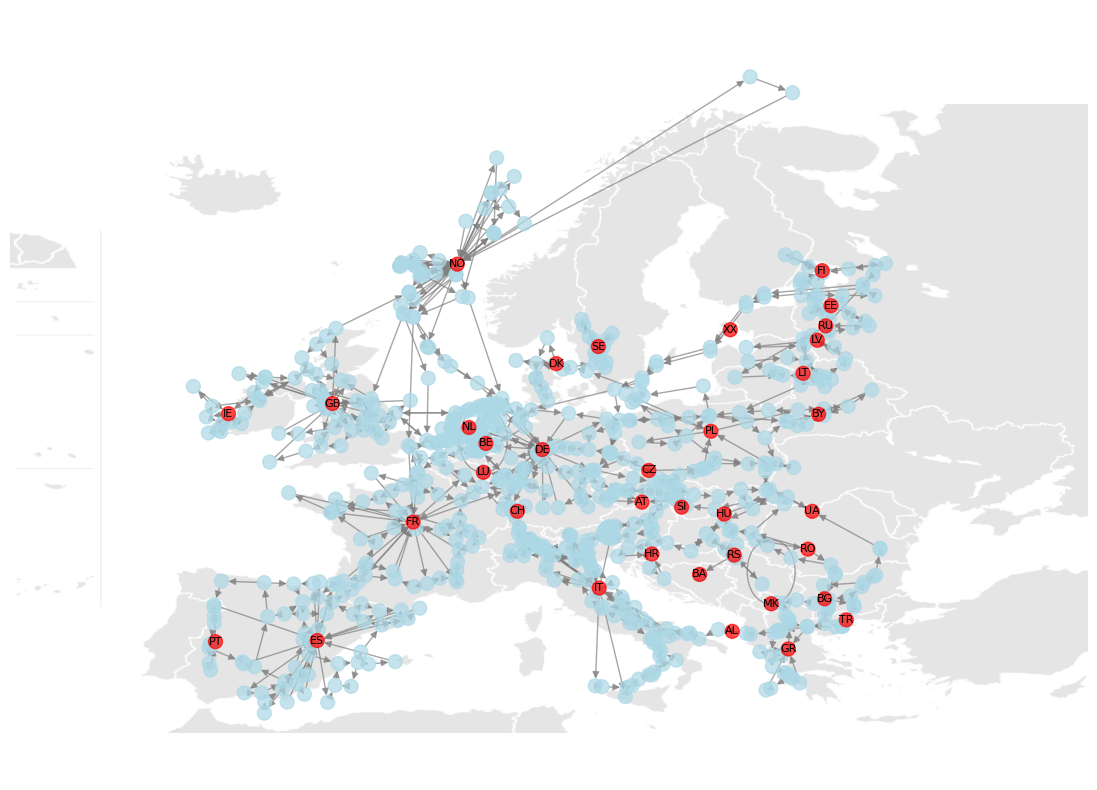

In [10]:
import matplotlib.image as mpimg
europe_map = mpimg.imread('Europe_blank_map.png')

plt.figure(figsize=(15, 10))
plt.imshow(europe_map, extent=[-20, 40, 35, 70], alpha=0.5)

pos = nx.get_node_attributes(G_with_country_nodes, 'pos')
node_colors = ['red' if G_with_country_nodes.nodes[node_id].get('is_country_node') else 'lightblue' for node_id in G_with_country_nodes.nodes]
nx.draw(G_with_country_nodes, pos=pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', width=1, alpha=0.7)

country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]
nx.draw_networkx_labels(G_with_country_nodes, pos=pos, labels={node_id: node_id for node_id in country_nodes}, font_color='black', font_size=8)

plt.show()

----
# Cai et al. 2021
### Capacity robustnes based on maximum flow.

In [12]:
import random

def W(flow_dict):
    """ 
    Computes flow matrix W after running max flow algorithm on the graph.
    Defined in Cai et al. (2021) as the flow matrix of the network prior to any node removal.
    
    Returns:
        flow_matrix: 2D numpy array representing the flow matrix
        node_indices: Dictionary mapping nodes to their corresponding indices
    """
    nodes = list(flow_dict.keys())
    num_nodes = len(nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    flow_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                flow_matrix[i, j] = flow_dict.get(nodes[i], {}).get(nodes[j], 0)
    
    return flow_matrix, node_indices


def W_c(flow_matrix, target, node_indices):
    """
    Computes the flow matrix W_c after removing a node.
    Defined in Cai et al. (2021) as the original flow matrix of the network after removing entry corresponding to the removed node.

    Parameters:
        flow_matrix: Flow matrix of the original graph
        target: Target can be either a single node or an edge in the form (v1, v2)
        node_indices: Dictionary mapping nodes to their indices in the flow matrix

    Returns:
        flow_matrix_c: Flow matrix after removing the specified node
        modified_flow_matrix: Modified flow matrix
    """

    modified_flow_matrix = np.copy(flow_matrix)

    if isinstance(target, (set,tuple)) and len(target) == 2:
        # Target is an edge in the form (v1, v2)
        v1, v2 = target
        index_v1 = node_indices.get(v1, None)
        index_v2 = node_indices.get(v2, None)

        if index_v1 is not None and index_v2 is not None:
            modified_flow_matrix[index_v1, index_v2] = 0
            modified_flow_matrix[index_v2, index_v1] = 0
    
    else:
        # Target is a single node
        removed_node_index = node_indices.get(target, None)

        # Exclude the row and column corresponding to the removed node
        if removed_node_index is not None and removed_node_index < modified_flow_matrix.shape[0]:
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=0)
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=1)

    return modified_flow_matrix

def check_validity(heuristic, remove, k_removals):
        if heuristic not in ['random', 'greedy', 'max_flow', 'congestion']:
            raise ValueError("Invalid heuristic")
        if remove not in ['node', 'edge']:
            raise ValueError("Invalid removal type")
        if not isinstance(k_removals, int) or k_removals < 1:
            raise ValueError("Invalid number of removals")
        if remove=='edge' and G.number_of_edges() < k_removals:
            raise ValueError("Too many edges to remove")
        if remove=='node' and G.number_of_nodes() < k_removals:
            raise ValueError("Too many nodes to remove")


In [60]:
def flow_capacity_robustness(G_, sources, sinks, k_removals, heuristic='random', remove='node', n_benchmarks = 100, all_to_all_flow=False):
    """ 
    Computes the n-k capacity robustness based on maximum flow of a graph
    Defined in Cai et al. (2021) as: sum(W_c_prime) / sum(W_c)
    """

    # Check the validity of the input arguments
    check_validity(heuristic, remove, k_removals)

    # Make a copy of the graph
    G = G_.copy()

    # Remove the country node abstractions from the graph
    country_nodes = [n for n in G.nodes if G.nodes[n].get('is_country_node') and n not in sources and n not in sinks]
    G.remove_nodes_from(country_nodes)

    # If all_to_all_flow is True, remove all country nodes and instead use all nodes as sources and sinks
    if all_to_all_flow:
        G.remove_nodes_from([n for n in G.nodes if G.nodes[n].get('is_country_node')])
        sources = [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) > 0]
        sinks = [n for n in G.nodes() if G.out_degree(n) == 0 and G.in_degree(n) > 0]

    # Calculate the original flow matrix W of the graph
    flow_val, flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
    flow_matrix, node_indices = W(flow_dict)

    # Instantiate the results dataframe
    results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity', 'entity_data', 'sources', 'sinks', 'network_state', 'flow_dict', 'comment'])
    results_df.loc[0] = [flow_val, 1, None, None, None, sources, sinks, G.copy(), flow_dict, 'No removals made']

    # Helper function to check if a node is valid
    def node_is_valid(n, sources, sinks, g):
        return n not in sources and n not in sinks and n != 'super_source' and n != 'super_sink' and n in g.nodes()
    
    # Helper function to check if an edge is valid
    def edge_is_valid(src, snk, sources, sinks, g):
        return src not in sources and snk not in sinks and src != 'super_source' and snk != 'super_sink' and (src, snk) in g.edges() 
    
    # Helper function to remove a node from the graph
    def remove_node(G, edge, df):
        if edge[0] not in sources:
            target = edge[0]
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        elif edge[1] not in sinks:
            target = edge[1]
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        elif edge[0] in sources:
            target = edge[0]
            sources.remove(target)
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        elif edge[1] in sinks:
            target = edge[1]
            sinks.remove(target)
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        else:
            return df, None

    # Helper function to perform a targeted removal   
    def perform_targeted_removal(G, heuristic, target, flow_matrix, node_indices, results_df):
        if remove == 'edge':
                target_data = G.get_edge_data(*target)
                G.remove_edge(*target)
        else:
            target, target_data = remove_node(G, target, results_df)
            if isinstance(target, pd.DataFrame):
                return results_df
            
        # Calculate the flow matrix W_c after removing the node or edge
        flow_matrix = W_c(flow_matrix, target, node_indices)
        W_c_ = flow_matrix

        # Recompute W_c_prime (flow matrix) after the network has sustained damage
        current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
        W_c_prime, _ = W(current_flow_dict)

        results_df.loc[k] = [current_max_flow_val, np.sum(W_c_prime) / np.sum(W_c_), heuristic, target, target_data, sources, sinks, G.copy(), current_flow_dict, None]
    
    # Heuristic specific initializations
    if heuristic == 'random':
        G_lst = [G.copy() for _ in range(n_benchmarks)]
        G_flow_matrix_lst = [flow_matrix for _ in range(n_benchmarks)]
    if heuristic == 'congestion':
        edge_capacities = {edge: G.edges[edge]['capacity'] for edge in G.edges()}

    # N-k capacity robustness calculation
    for k in tqdm(range(1, k_removals + 1), desc='N-k capacity robustness'):

        if heuristic == 'random':
            max_flow_lst, capacity_robustness_lst = [], []

            for G_copy, G_flow_matrix in zip(G_lst, G_flow_matrix_lst):

                valid_targets = [target for target in (G_copy.nodes() if remove == 'node' else G_copy.edges()) if node_is_valid(target, sources, sinks, G_copy) or edge_is_valid(target[0], target[1], sources, sinks, G_copy)]
                target = random.choice(valid_targets)
                
                if remove == 'edge':
                    target_data = G_copy.get_edge_data(*target)
                    G_copy.remove_edge(*target)
                else:
                    target_data = G_copy.nodes[target]
                    G_copy.remove_node(target)

                G_flow_matrix = W_c(G_flow_matrix, target, node_indices)
                W_c_ = G_flow_matrix

                current_max_flow_val, current_flow_dict, _ = utils.max_flow(G_copy, sources, sinks, show_plot=False)
                W_c_prime, _ = W(current_flow_dict)

                capacity_robustness_lst.append(np.sum(W_c_prime) / np.sum(W_c_))
                max_flow_lst.append(current_max_flow_val)

            results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target, target_data, sources, sinks, G_copy.copy(), current_flow_dict,'Specimen graph, averaged across '+str(n_benchmarks)+' benchmarks']

        
        elif heuristic == 'congestion':
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)

            flow_edges = {(source, target): flow for source, targets in current_flow_dict.items() for target, flow in targets.items() if flow != 0}
            sorted_edge_loads = dict(sorted({edge: flow / edge_capacities[edge] for edge, flow in flow_edges.items() if edge in edge_capacities}.items(), key=lambda item: item[1], reverse=True))
            
            if len(sorted_edge_loads) == 0:
                return results_df
            
            target = list(sorted_edge_loads.keys())[0]
     
            perform_targeted_removal(G, 'congestion', target, flow_matrix, node_indices, results_df)
        

        elif heuristic == 'max_flow':
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)

            # Find the edge that maximizes the flow
            max_flow, target = float('-inf'), None
            max_flow, target = max(((flow, (source, sink)) for source, edges in current_flow_dict.items() for sink, flow in edges.items() if edge_is_valid(source, sink, sources, sinks, G) and node_is_valid(source, sources, sinks, G) and flow > max_flow), key=lambda x: x[0], default=(float('-inf'), None))
    
            perform_targeted_removal(G, 'max_flow', target, flow_matrix, node_indices, results_df)

        
        # Other heuristics


        else:
            raise ValueError("Invalid heuristic")


    return results_df

In [14]:
n_benchmarks = 50

sources = ['NO', 'RU']
sinks = ['DE', 'FR']

----
# Heuristics

## Congestion heuristic

### Node removal

#### All-to-all flow

In [57]:
# congestion_node_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='congestion', remove='node', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# congestion_node_removal_all_to_all_df.to_pickle('results/congestion_node_removal_all_to_all_df.pkl')

congestion_node_removal_all_to_all_df = pd.read_pickle('results/congestion_node_removal_all_to_all_df.pkl')
congestion_node_removal_all_to_all_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,4724.910577,1.000000,None,None,None,"[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,4681.768521,0.990718,congestion,NO_N_4,"{'pos': (3.2983729818980376, 54.78877197821838...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,4632.259340,0.988539,congestion,NO_N_7,"{'pos': (3.724809886770192, 60.645132639754706...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,4586.938238,0.991443,congestion,NO_N_9,"{'pos': (1.8284935777353344, 61.20640953392480...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,4535.708212,0.988524,congestion,NO_N_10,"{'pos': (8.086519727006019, 66.02707314385772)...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
...,...,...,...,...,...,...,...,...,...,...
105,182.041270,0.043773,congestion,INET_N_658,"{'pos': (24.2, 56.59), 'country_code': 'LV', '...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_3, NO_N_6, NO_N_8, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
106,136.530952,0.036235,congestion,INET_N_720,"{'pos': (23.4243, 41.1221), 'country_code': 'G...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_3, NO_N_6, NO_N_8, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
107,91.020635,0.025882,congestion,INET_N_325,"{'pos': (-8.732999999999999, 53.23), 'country_...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_3, NO_N_6, NO_N_8, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
108,45.510317,0.012941,congestion,INET_N_971,"{'pos': (-8.158999999999999, 52.26699999999999...","[NO_N_0, NO_N_22, NO_N_28, NO_N_34, NO_N_35, N...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_3, NO_N_6, NO_N_8, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None


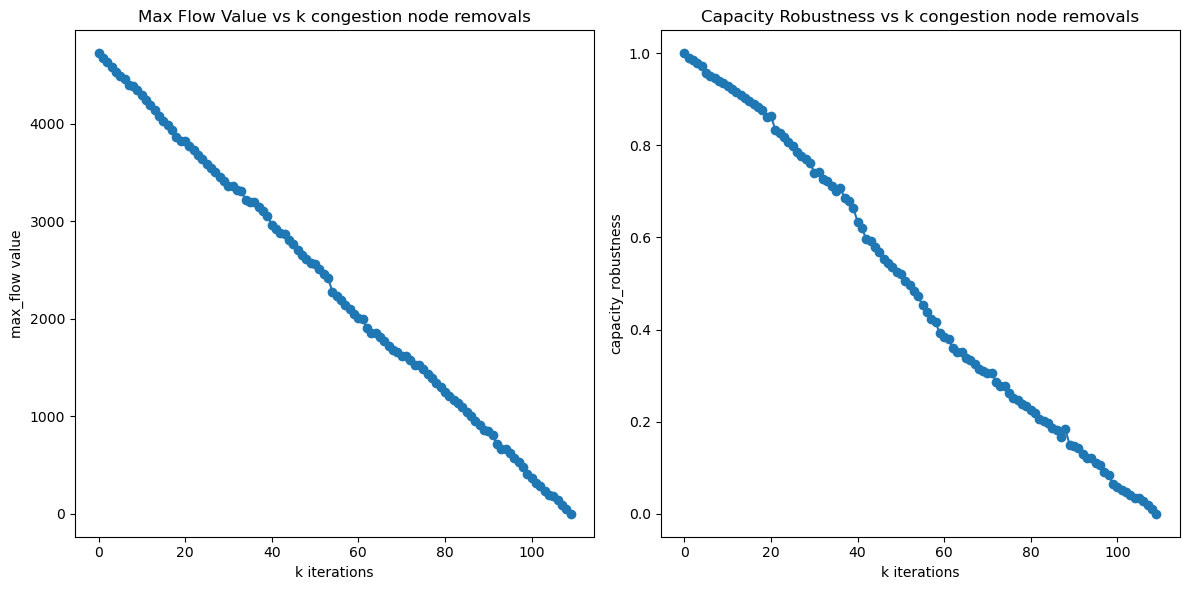

In [55]:
utils.plot_biplot(congestion_node_removal_all_to_all_df)

#### Geopolitical flow

In [61]:
# congestion_node_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='congestion', remove='node', n_benchmarks=n_benchmarks)
# congestion_node_removal_geopolitical_df.to_pickle('results/congestion_node_removal_geopolitical_df.pkl')

congestion_node_removal_geopolitical_df = pd.read_pickle('results/congestion_node_removal_geopolitical_df.pkl')
congestion_node_removal_geopolitical_df

N-k capacity robustness:   2%|▏         | 6/250 [00:01<00:40,  6.00it/s]


,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,250.159923,0.863832,congestion,NO_N_4,"{'pos': (3.2983729818980376, 54.78877197821838...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,206.290137,0.633960,congestion,NO_N_12,"{'pos': (3.328996874261654, 56.48970565360146)...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,151.290137,0.574158,congestion,NO_N_32,"{'pos': (2.46506517720123, 58.188080675194165)...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,41.368490,0.281082,congestion,INET_N_435,"{'pos': (9.022361, 53.0268), 'country_code': '...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
5,35.068490,0.228027,congestion,INET_N_698,"{'pos': (25.007620000000003, 54.941019), 'coun...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
6,0.000000,0.000000,congestion,INET_N_1215,"{'pos': (9.788964, 50.785275), 'country_code':...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None


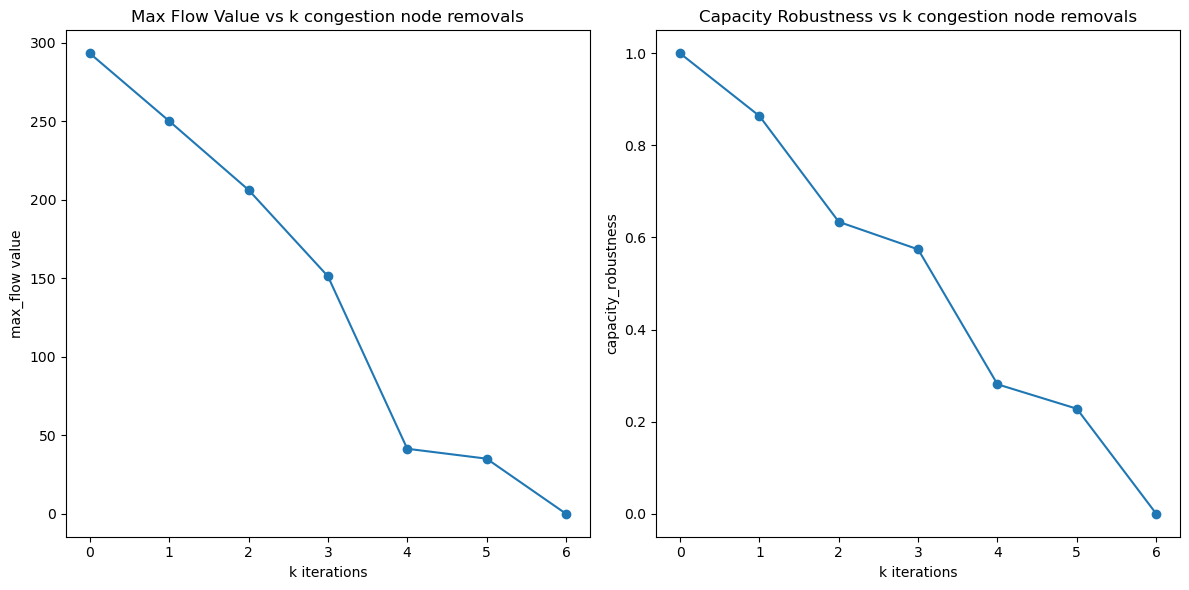

In [62]:
utils.plot_biplot(congestion_node_removal_geopolitical_df)

### Edge removal

#### All-to-all flow

In [19]:
# congestion_edge_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='congestion', remove='edge', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# congestion_edge_removal_all_to_all_df.to_pickle('results/congestion_edge_removal_all_to_all_df.pkl')

congestion_edge_removal_all_to_all_df = pd.read_pickle('results/congestion_edge_removal_all_to_all_df.pkl')
congestion_edge_removal_all_to_all_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,4724.910577,1.000000,None,None,None,"[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,4681.768521,0.988883,congestion,"(NO_N_4, INET_N_1656)","{'diameter_mm': 1016.0, 'length_km': 389.48382...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,4632.259340,0.984597,congestion,"(NO_N_7, NO_N_8)","{'diameter_mm': 914.0, 'length_km': 65.6496726...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,4586.938238,0.980658,congestion,"(NO_N_9, NO_N_44)","{'diameter_mm': 813.0, 'length_km': 24.0138735...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,4535.708212,0.976187,congestion,"(NO_N_10, NO_N_11)","{'diameter_mm': 406.0, 'length_km': 128.265431...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
...,...,...,...,...,...,...,...,...,...,...
134,136.530952,0.034412,congestion,"(INET_N_720, INET_N_1393)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
135,99.787758,0.027489,congestion,"(INET_N_325, INET_N_1166)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
136,91.020635,0.024652,congestion,"(INET_N_886, INET_N_555)","{'diameter_mm': 610.0, 'length_km': 13.6183640...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
137,45.510317,0.012357,congestion,"(INET_N_84, INET_N_971)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None


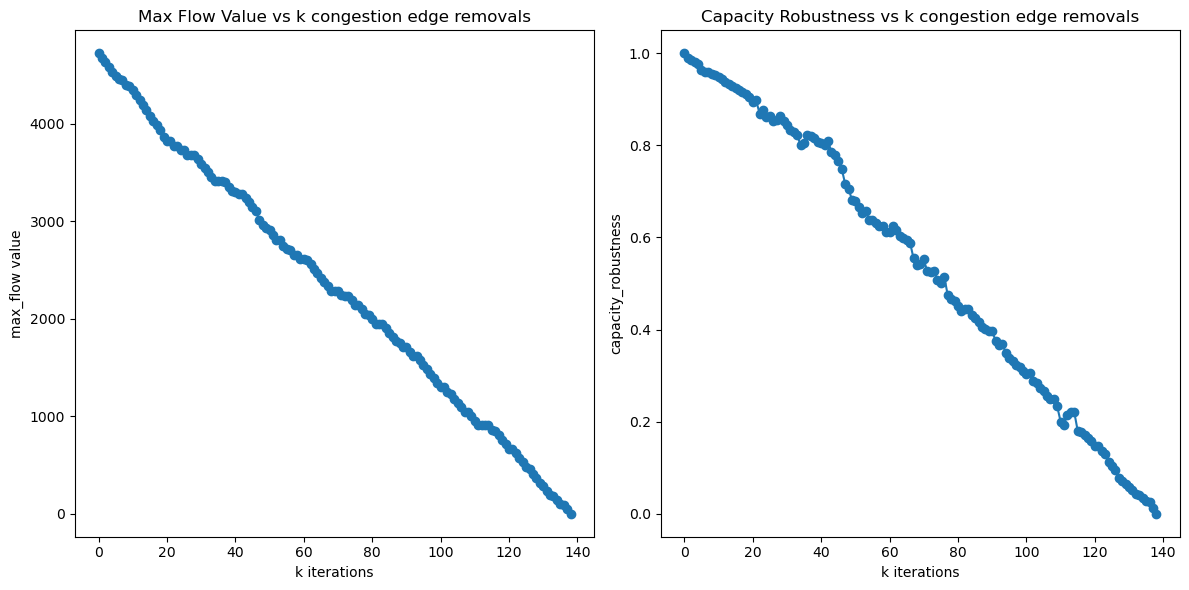

In [20]:
utils.plot_biplot(congestion_edge_removal_all_to_all_df)

#### Geopolitical flow

In [21]:
# congestion_edge_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='congestion', remove='edge', n_benchmarks=n_benchmarks)
# congestion_edge_removal_geopolitical_df.to_pickle('results/congestion_edge_removal_geopolitical_df.pkl')

congestion_edge_removal_geopolitical_df = pd.read_pickle('results/congestion_edge_removal_geopolitical_df.pkl')
congestion_edge_removal_geopolitical_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,250.159923,0.855418,congestion,"(NO_N_4, INET_N_1656)","{'diameter_mm': 1016.0, 'length_km': 389.48382...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,206.290137,0.633854,congestion,"(NO_N_12, NO_N_13)","{'diameter_mm': 914.0, 'length_km': 138.237576...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,151.290137,0.578402,congestion,"(NO_N_32, INET_N_407)","{'diameter_mm': 1067.0, 'length_km': 834.23492...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,99.998627,0.388806,congestion,"(INET_N_435, INET_N_1219)","{'diameter_mm': 1422.0, 'length_km': 58.093189...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
5,41.368490,0.282988,congestion,"(INET_N_435, INET_N_1419)","{'diameter_mm': 1200.0, 'length_km': 141.86369...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
6,41.368490,0.284907,congestion,"(INET_N_698, INET_N_426)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
7,6.300000,0.043716,congestion,"(INET_N_1215, INET_N_891)","{'diameter_mm': 800.0, 'length_km': 176.912658...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
8,0.000000,0.000000,congestion,"(INET_N_426, INET_N_50)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None


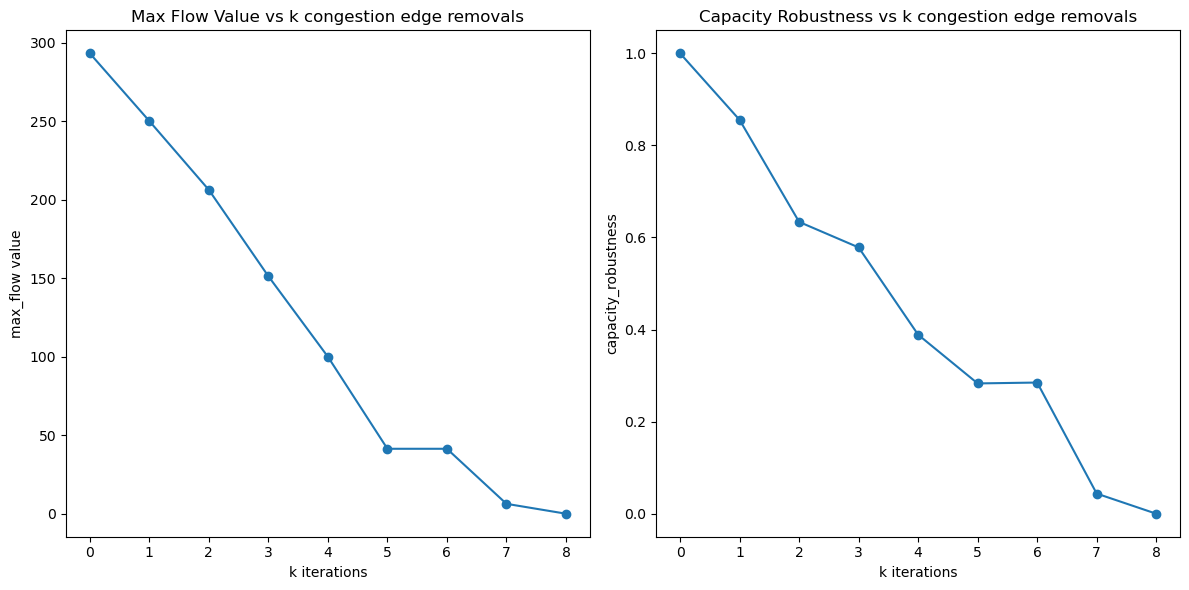

In [22]:
utils.plot_biplot(congestion_edge_removal_geopolitical_df)

## Random heuristic

### Node removal

#### All-to-all flow

In [23]:
# random_node_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='node', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# random_node_removal_all_to_all_df.to_pickle('results/random_node_removal_all_to_all_df.pkl')

random_node_removal_all_to_all_df = pd.read_pickle('results/random_node_removal_all_to_all_df.pkl')
random_node_removal_all_to_all_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,4724.910577,1.000000,None,None,None,"[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,4704.204569,0.995898,random,INET_N_1230,"{'pos': (13.48, 48.21), 'country_code': 'AT', ...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
2,4694.564296,0.991977,random,INET_N_418,"{'pos': (9.312291900000002, 55.617559), 'count...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
3,4681.586882,0.990046,random,INET_N_358,"{'pos': (13.472999999999999, 50.621), 'country...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
4,4669.023072,0.985157,random,INET_N_1576,"{'pos': (4.010777, 46.352556), 'country_code':...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
...,...,...,...,...,...,...,...,...,...,...
246,2505.093004,0.377539,random,INET_N_1024,"{'pos': (26.6765, 53.2247), 'country_code': 'B...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
247,2501.089917,0.376640,random,INET_N_31,"{'pos': (-3.5458019999999997, 40.585921), 'cou...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
248,2497.207998,0.375703,random,INET_N_167,"{'pos': (23.4907078, 44.7815366), 'country_cod...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
249,2493.304776,0.374933,random,INET_N_467,"{'pos': (5.212561, 46.336132), 'country_code':...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"


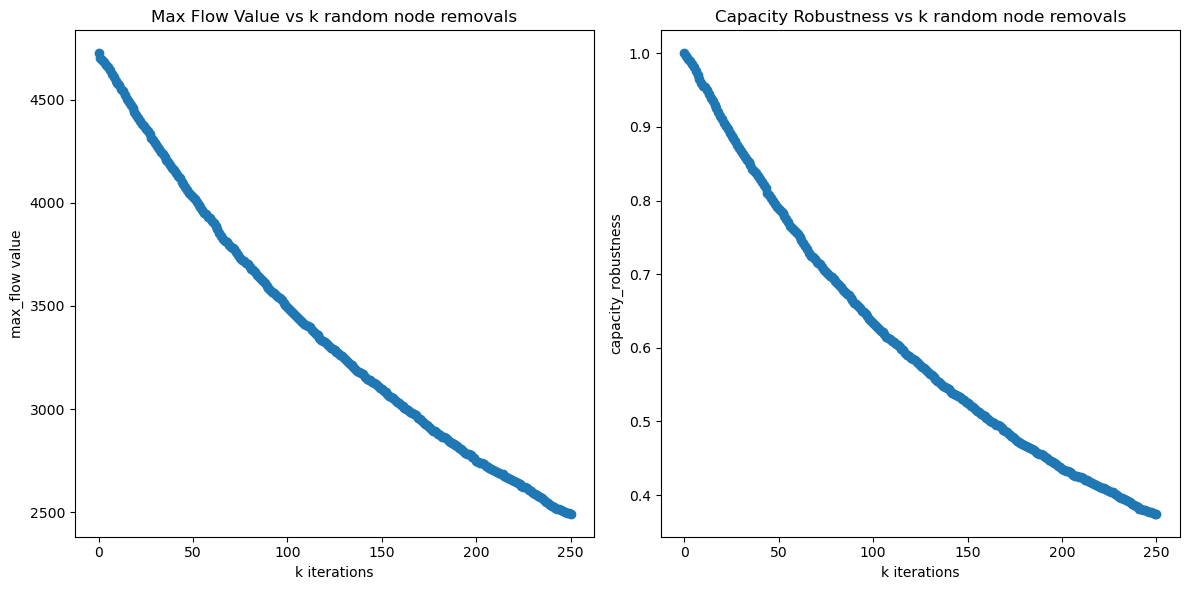

In [24]:
utils.plot_biplot(random_node_removal_all_to_all_df)

#### Geopolitical flow

In [25]:
# random_node_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='node', n_benchmarks=n_benchmarks)
# random_node_removal_geopolitical_df.to_pickle('results/random_node_removal_geopolitical_df.pkl')

random_node_removal_geopolitical_df = pd.read_pickle('results/random_node_removal_geopolitical_df.pkl')
random_node_removal_geopolitical_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,289.150119,0.971570,random,INET_N_1597,"{'pos': (7.9, 47.566), 'country_code': 'DE', '...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
2,285.452832,0.956303,random,INET_N_643,"{'pos': (15.879423999999998, 49.0055), 'countr...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
3,283.124943,0.941032,random,INET_N_1155,"{'pos': (21.124868, 50.013802), 'country_code'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
4,280.710442,0.931908,random,INET_N_970,"{'pos': (12.131102, 45.426978999999996), 'coun...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
...,...,...,...,...,...,...,...,...,...,...
246,37.660469,0.057127,random,INET_N_646,"{'pos': (-0.436, 42.231), 'country_code': 'ES'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
247,37.660469,0.057207,random,INET_N_589,"{'pos': (21.366312, 47.507335), 'country_code'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
248,37.660469,0.057082,random,INET_N_559,"{'pos': (2.699989, 49.526019), 'country_code':...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
249,37.660469,0.057144,random,INET_N_561,"{'pos': (15.991103599999999, 47.3404037), 'cou...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_6, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"


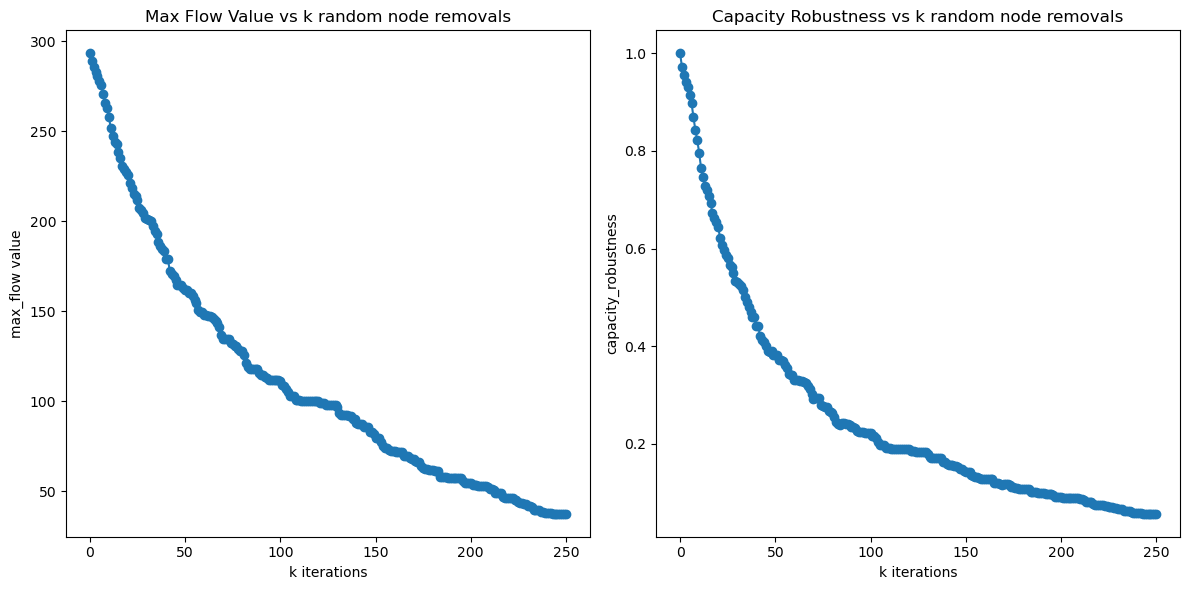

In [26]:
utils.plot_biplot(random_node_removal_geopolitical_df)

### Edge removal

#### All-to-all flow

In [27]:
# random_edge_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='edge', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# random_edge_removal_all_to_all_df.to_pickle('results/random_edge_removal_all_to_all_df.pkl')

random_edge_removal_all_to_all_df = pd.read_pickle('results/random_edge_removal_all_to_all_df.pkl')
random_edge_removal_all_to_all_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,4724.910577,1.000000,None,None,None,"[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,4714.812078,0.997968,random,"(INET_N_967, INET_N_272)","{'diameter_mm': 914.0, 'length_km': 73.6628079...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
2,4707.420290,0.995656,random,"(INET_N_877, INET_N_339)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
3,4698.752955,0.992088,random,"(INET_N_1020, INET_N_863)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
4,4686.810274,0.987303,random,"(INET_N_426, INET_N_50)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
...,...,...,...,...,...,...,...,...,...,...
246,3340.306917,0.562146,random,"(INET_N_284, INET_N_473)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...","Specimen graph, averaged across 50 benchmarks"
247,3338.359304,0.561609,random,"(INET_N_1623, INET_N_958)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...","Specimen graph, averaged across 50 benchmarks"
248,3334.456082,0.560798,random,"(INET_N_56, INET_N_206)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...","Specimen graph, averaged across 50 benchmarks"
249,3329.905051,0.559837,random,"(INET_N_1201, INET_N_105)","{'diameter_mm': 1200.0, 'length_km': 14.696288...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...","Specimen graph, averaged across 50 benchmarks"


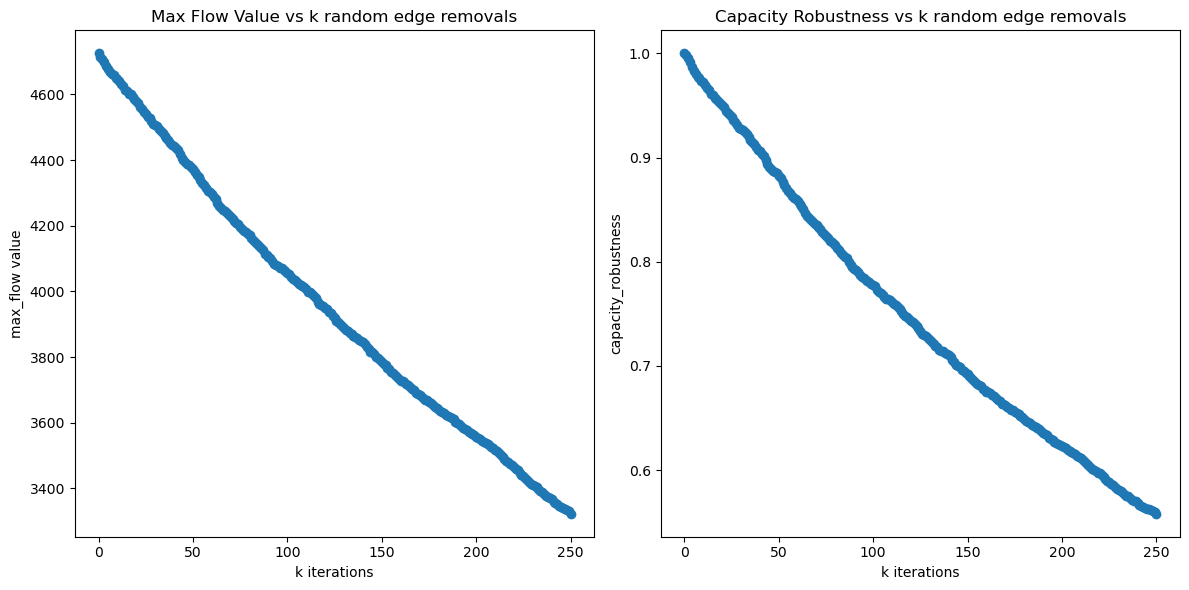

In [28]:
utils.plot_biplot(random_edge_removal_all_to_all_df)

#### Geopolitical flow

In [29]:
# random_edge_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='edge', n_benchmarks=n_benchmarks)
# random_edge_removal_geopolitical_df.to_pickle('results/random_edge_removal_geopolitical_df.pkl')

random_edge_removal_geopolitical_df = pd.read_pickle('results/random_edge_removal_geopolitical_df.pkl')
random_edge_removal_geopolitical_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,290.151730,0.978537,random,"(INET_N_1550, INET_N_1520)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
2,281.614230,0.933359,random,"(INET_N_1360, INET_N_1113)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
3,279.168604,0.916880,random,"(INET_N_1635, INET_N_421)","{'diameter_mm': 1000.0, 'length_km': 37.993066...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
4,276.931742,0.905766,random,"(INET_N_1133, INET_N_299)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...","Specimen graph, averaged across 50 benchmarks"
...,...,...,...,...,...,...,...,...,...,...
246,77.211375,0.124732,random,"(INET_N_249, INET_N_970)","{'diameter_mm': 762.0, 'length_km': 8.60442650...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {'NO_N_17': 0}, 'NO_N...","Specimen graph, averaged across 50 benchmarks"
247,76.346419,0.122419,random,"(INET_N_695, INET_N_314)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {'NO_N_17': 0}, 'NO_N...","Specimen graph, averaged across 50 benchmarks"
248,76.346419,0.122314,random,"(NO_N_41, NO)",{'capacity': 49.05305403546818},"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {'NO_N_17': 0}, 'NO_N...","Specimen graph, averaged across 50 benchmarks"
249,75.921934,0.120423,random,"(INET_N_877, INET_N_339)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {'NO_N_17': 0}, 'NO_N...","Specimen graph, averaged across 50 benchmarks"


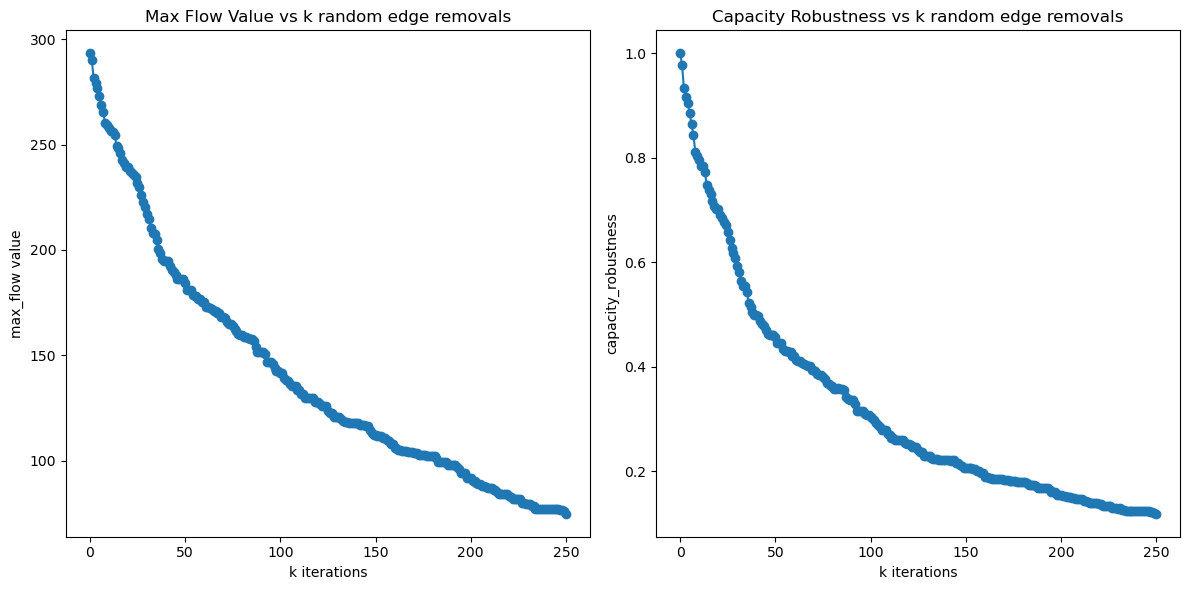

In [30]:
utils.plot_biplot(random_edge_removal_geopolitical_df)

## Max flow heuristic

### Node removal

#### All-to-all flow

In [31]:
# max_flow_node_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=150, heuristic='max_flow', remove='node', all_to_all_flow=True)
# max_flow_node_removal_all_to_all_df.to_pickle('results/max_flow_node_removal_all_to_all_df.pkl')

max_flow_node_removal_all_to_all_df = pd.read_pickle('results/max_flow_node_removal_all_to_all_df.pkl')
max_flow_node_removal_all_to_all_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,4724.910577,1.000000,None,None,None,"[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,4634.499618,0.974624,max_flow,INET_N_301,"{'pos': (20.6197948, 52.8814838), 'country_cod...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,4574.225646,0.962838,max_flow,INET_N_1240,"{'pos': (9.948338, 49.841916), 'country_code':...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,4568.359141,0.972666,max_flow,INET_N_1599,"{'pos': (8.171742, 53.074963000000004), 'count...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,4513.564621,0.955185,max_flow,INET_N_952,"{'pos': (26.325508000000003, 40.98095700000000...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
...,...,...,...,...,...,...,...,...,...,...
146,2355.200766,0.480647,max_flow,INET_N_1556,"{'pos': (19.769095, 46.823766), 'country_code'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_2, NO_N_3, NO_N_6, NO_N_7, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {'NO_N_3': 45.1345037...",None
147,2355.200766,0.480647,max_flow,INET_N_1559,"{'pos': (16.5895288, 45.606141), 'country_code...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_2, NO_N_3, NO_N_6, NO_N_7, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {'NO_N_3': 45.1345037...",None
148,2355.200766,0.488219,max_flow,INET_N_1576,"{'pos': (4.010777, 46.352556), 'country_code':...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_2, NO_N_3, NO_N_6, NO_N_7, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {'NO_N_3': 45.1345037...",None
149,2355.200766,0.492523,max_flow,INET_N_1584,"{'pos': (5.14, 47.95245), 'country_code': 'FR'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_2, NO_N_3, NO_N_6, NO_N_7, NO_N_...","{'NO_N_0': {}, 'NO_N_2': {'NO_N_3': 45.1345037...",None


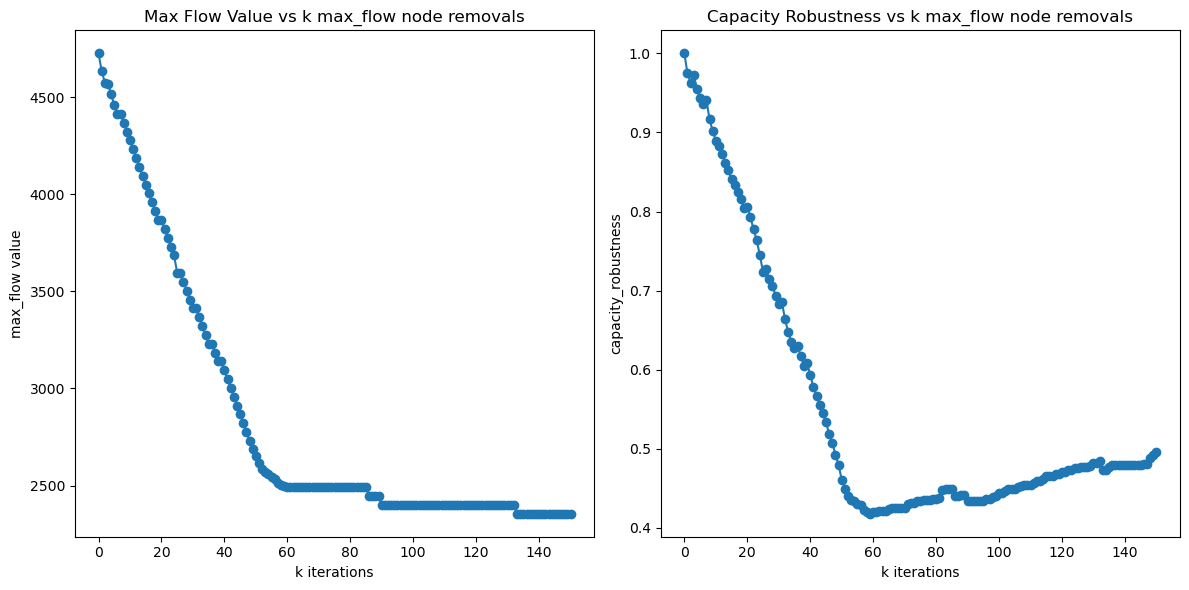

In [32]:
utils.plot_biplot(max_flow_node_removal_all_to_all_df)

#### Geopolitical flow

In [33]:
# max_flow_node_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=10, heuristic='max_flow', remove='node')
# max_flow_node_removal_geopolitical_df.to_pickle('results/max_flow_node_removal_geopolitical_df.pkl')

max_flow_node_removal_geopolitical_df = pd.read_pickle('results/max_flow_node_removal_geopolitical_df.pkl')
max_flow_node_removal_geopolitical_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,213.301979,0.653146,max_flow,INET_N_1172,"{'pos': (28.065696000000003, 60.5549), 'countr...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,154.671842,0.597959,max_flow,INET_N_435,"{'pos': (9.022361, 53.0268), 'country_code': '...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,99.671842,0.545333,max_flow,NO_N_32,"{'pos': (2.46506517720123, 58.188080675194165)...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,56.529786,0.428524,max_flow,INET_N_1656,"{'pos': (3.213, 51.323), 'country_code': 'BE',...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
5,12.660000,0.122255,max_flow,NO_N_12,"{'pos': (3.328996874261654, 56.48970565360146)...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
6,0.000000,0.000000,max_flow,INET_N_1287,"{'pos': (23.0480199, 54.952670999999995), 'cou...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
7,0.000000,0.000000,max_flow,NO_N_0,"{'pos': (6.797201226775478, 65.10639924578797)...","[NO, RU]","[DE, FR]","(NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_6, NO_N_...","{'NO_N_1': {'NO_N_17': 0}, 'NO_N_2': {'NO_N_3'...",None
8,0.000000,0.000000,max_flow,NO_N_1,"{'pos': (5.193570754034167, 59.33285970703154)...","[NO, RU]","[DE, FR]","(NO_N_2, NO_N_3, NO_N_4, NO_N_6, NO_N_7, NO_N_...","{'NO_N_2': {'NO_N_3': 0}, 'NO_N_3': {'NO': 0},...",None
9,0.000000,0.000000,max_flow,NO_N_2,"{'pos': (2.895754899438161, 60.56023487203963)...","[NO, RU]","[DE, FR]","(NO_N_3, NO_N_4, NO_N_6, NO_N_7, NO_N_8, NO_N_...","{'NO_N_3': {'NO': 0}, 'NO_N_4': {}, 'NO_N_6': ...",None


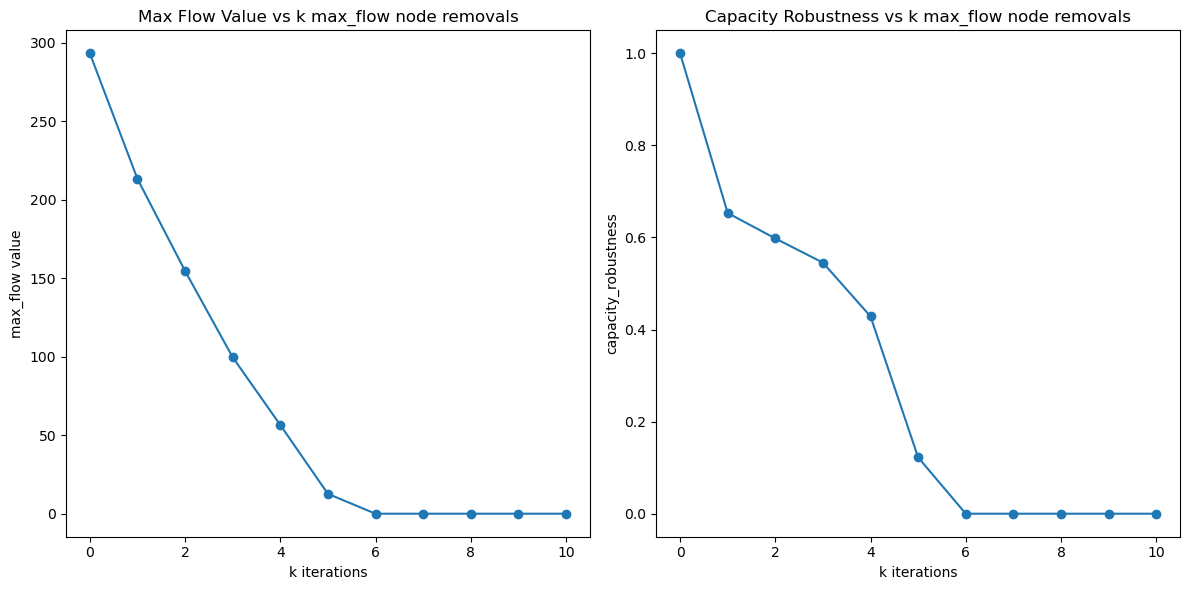

In [34]:
utils.plot_biplot(max_flow_node_removal_geopolitical_df)

### Edge removal

#### All-to-all flow

In [35]:
# max_flow_edge_removal_all_to_all_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='max_flow', remove='edge', all_to_all_flow=True)
# max_flow_edge_removal_all_to_all_df.to_pickle('results/max_flow_edge_removal_all_to_all_df.pkl')

max_flow_edge_removal_all_to_all_df = pd.read_pickle('results/max_flow_edge_removal_all_to_all_df.pkl')
max_flow_edge_removal_all_to_all_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,4724.910577,1.000000,None,None,None,"[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,4634.499618,0.970832,max_flow,"(INET_N_301, INET_N_1630)","{'diameter_mm': 1420.0, 'length_km': 113.37161...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,4574.225646,0.957805,max_flow,"(INET_N_1240, INET_N_536)","{'diameter_mm': 1100.0, 'length_km': 100.93613...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,4568.359141,0.970036,max_flow,"(INET_N_1599, INET_N_435)","{'diameter_mm': 1200.0, 'length_km': 57.124536...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,4513.564621,0.954865,max_flow,"(INET_N_952, INET_N_752)","{'diameter_mm': 1219.0, 'length_km': 1.9360476...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
...,...,...,...,...,...,...,...,...,...,...
246,2550.940636,0.421627,max_flow,"(INET_N_1629, INET_N_606)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...",None
247,2550.940636,0.421627,max_flow,"(INET_N_1630, INET_N_840)","{'diameter_mm': 1420.0, 'length_km': 300.13059...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...",None
248,2550.940636,0.422591,max_flow,"(INET_N_1630, INET_N_1644)","{'diameter_mm': 1420.0, 'length_km': 289.67864...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...",None
249,2550.940636,0.423546,max_flow,"(INET_N_1630, INET_N_1221)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO_N_0, NO_N_7, NO_N_9, NO_N_10, NO_N_14, NO_...","[NO_N_3, NO_N_8, NO_N_11, NO_N_15, NO_N_21, NO...","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {}, 'NO_N_...",None


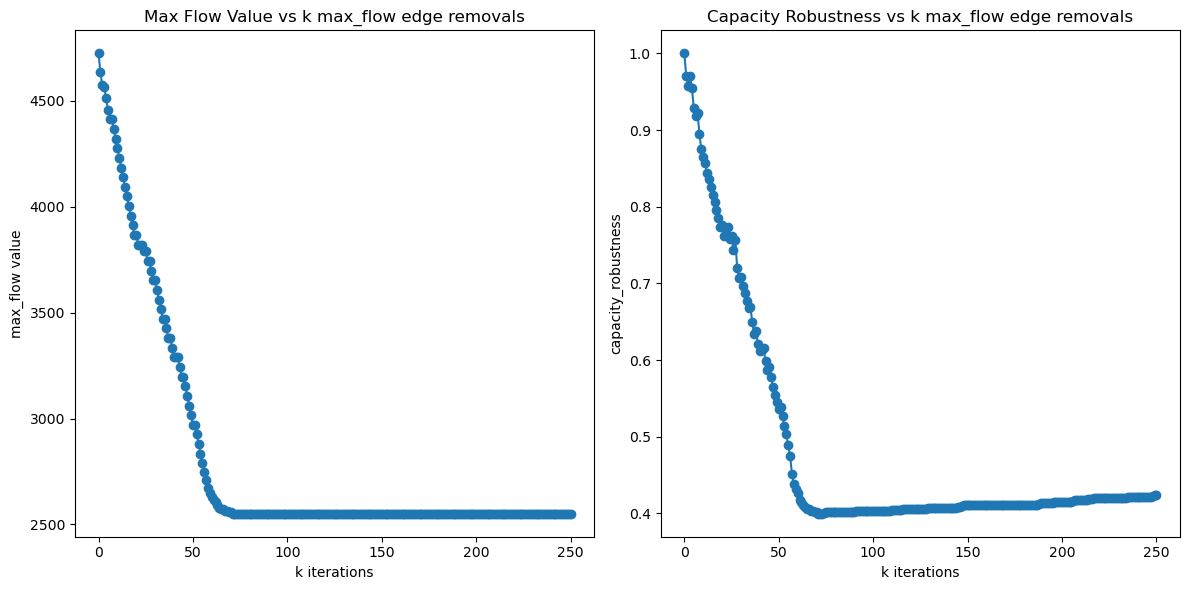

In [36]:
utils.plot_biplot(max_flow_edge_removal_all_to_all_df)

#### Geopolitical flow

In [37]:
# max_flow_edge_removal_geopolitical_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=10, heuristic='max_flow', remove='edge')
# max_flow_edge_removal_geopolitical_df.to_pickle('results/max_flow_edge_removal_geopolitical_df.pkl')

max_flow_edge_removal_geopolitical_df = pd.read_pickle('results/max_flow_edge_removal_geopolitical_df.pkl')
max_flow_edge_removal_geopolitical_df

,max_flow_value,capacity_robustness_max_flow,heuristic,removed_entity,entity_data,sources,sinks,network_state,flow_dict,comment
0,293.301979,1.000000,None,None,None,"[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",No removals made
1,213.301979,0.641250,max_flow,"(INET_N_1172, INET_N_1052)","{'diameter_mm': 1153.0, 'length_km': 69.157053...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
2,209.466342,0.691884,max_flow,"(INET_N_435, INET_N_1419)","{'diameter_mm': 1200.0, 'length_km': 141.86369...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
3,154.466342,0.636509,max_flow,"(NO_N_32, INET_N_407)","{'diameter_mm': 1067.0, 'length_km': 834.23492...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
4,99.671842,0.513261,max_flow,"(INET_N_435, INET_N_1219)","{'diameter_mm': 1422.0, 'length_km': 58.093189...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
5,58.170317,0.346436,max_flow,"(INET_N_1656, INET_N_912)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
6,12.660000,0.114892,max_flow,"(INET_N_164, INET_N_387)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
7,0.000000,0.000000,max_flow,"(INET_N_1287, INET_N_708)","{'diameter_mm': 923.7925292425738, 'length_km'...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {'NO_N_1': 0}, 'NO_N_1': {'NO_N_17'...",None
8,0.000000,0.000000,max_flow,"(NO_N_0, NO_N_1)","{'diameter_mm': 1067.0, 'length_km': 691.33166...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {'NO_N_17': 0}, 'NO_N...",None
9,0.000000,0.000000,max_flow,"(NO_N_1, NO_N_17)","{'diameter_mm': 711.0, 'length_km': 206.669475...","[NO, RU]","[DE, FR]","(NO_N_0, NO_N_1, NO_N_2, NO_N_3, NO_N_4, NO_N_...","{'NO_N_0': {}, 'NO_N_1': {}, 'NO_N_2': {'NO_N_...",None


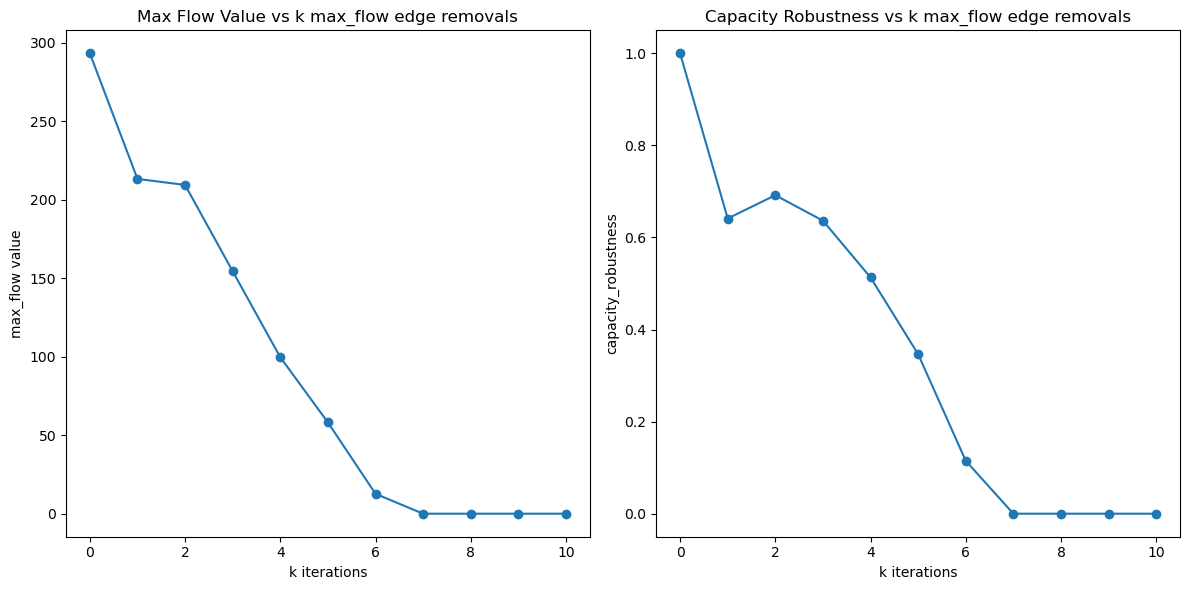

In [38]:
utils.plot_biplot(max_flow_edge_removal_geopolitical_df)

----
# Iterative visualization of flow capacity robustness

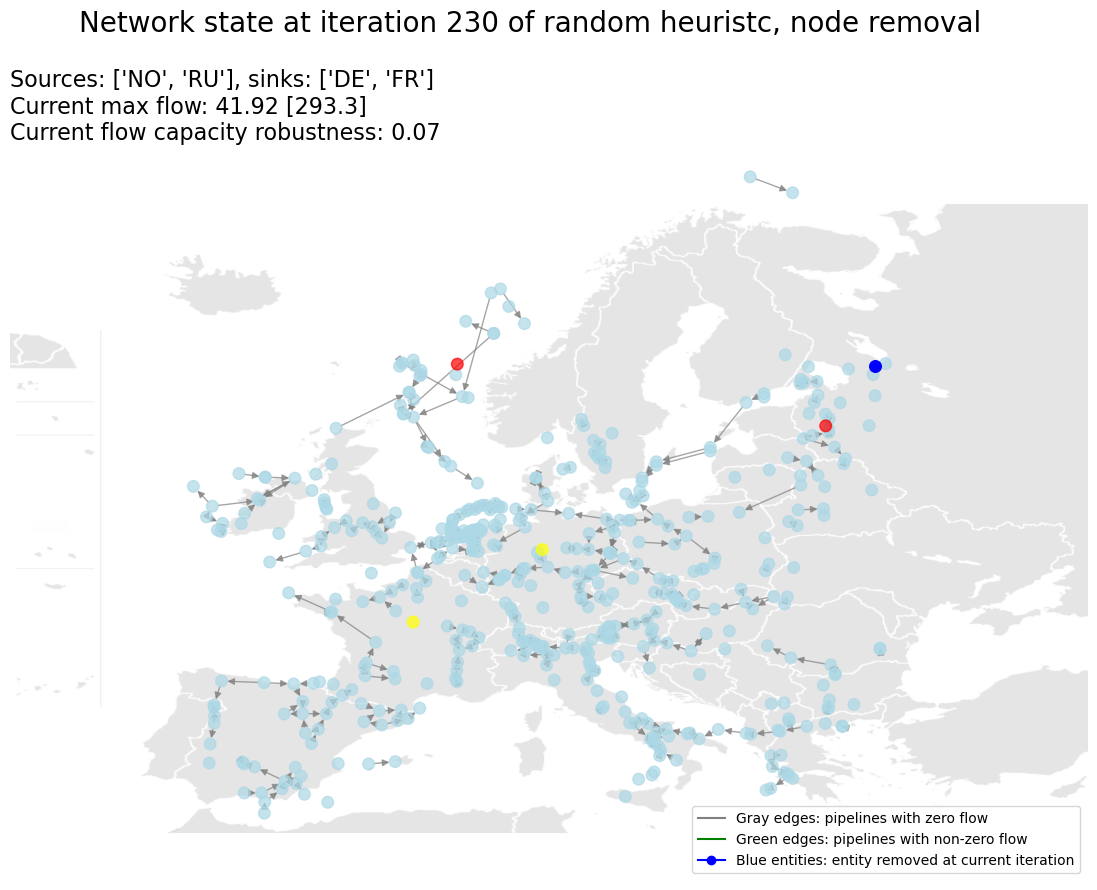

In [39]:
utils.visualize_network_state(random_node_removal_geopolitical_df, iteration=230, only_flow_edges=False)

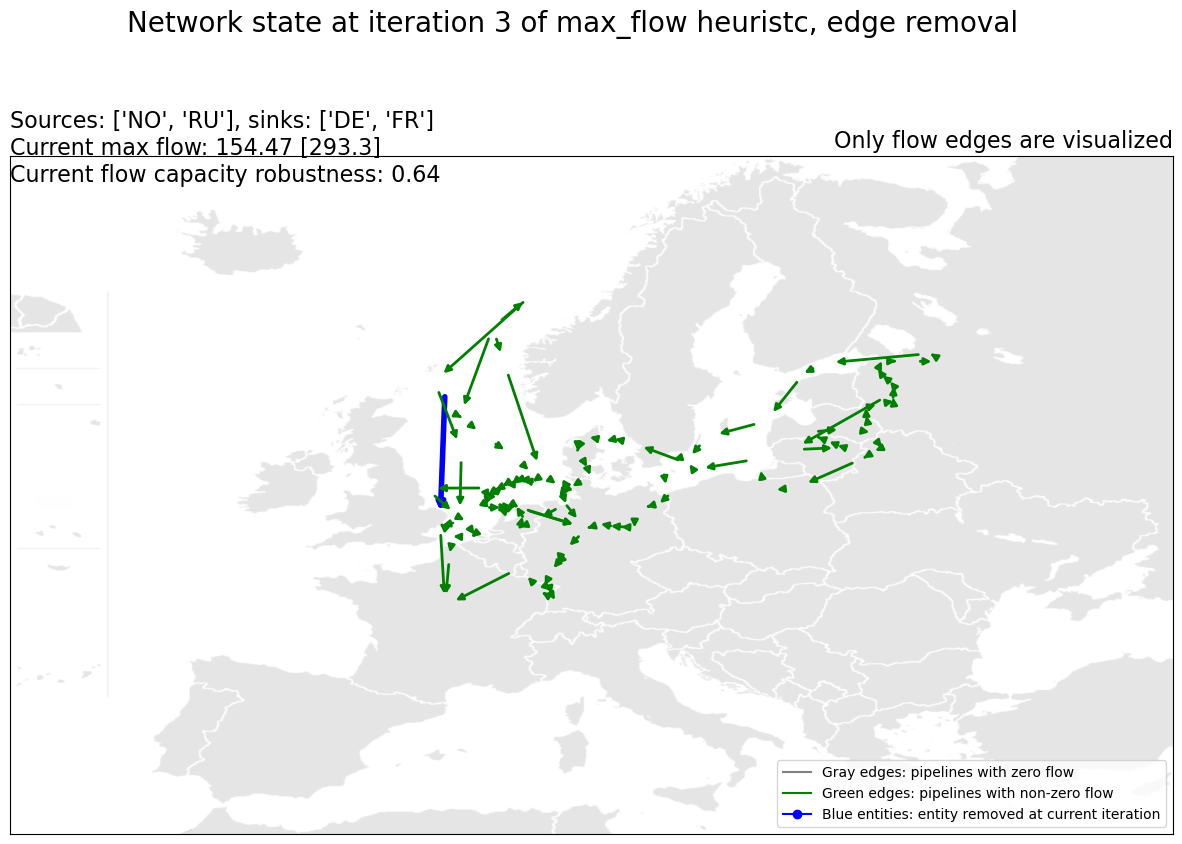

In [40]:
utils.visualize_network_state(max_flow_edge_removal_geopolitical_df, iteration=3, only_flow_edges=True)

----
# Comparison of grid performance across heuristics

## Node, all-to-all

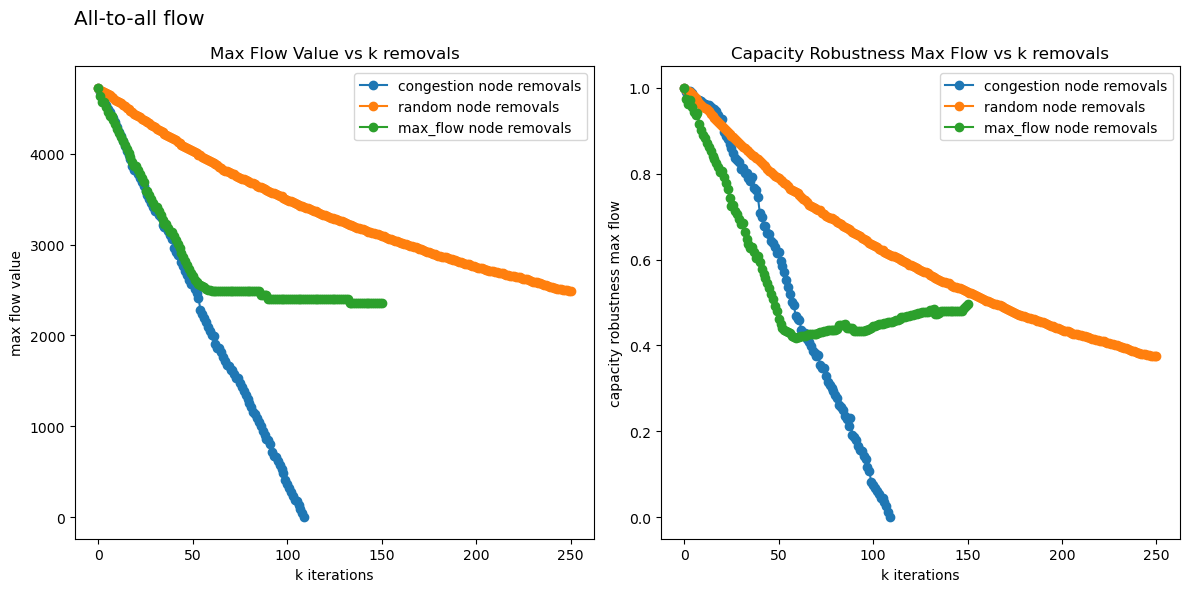

In [41]:
congestion_node_removal_all_to_all_df = pd.read_pickle('results/congestion_node_removal_all_to_all_df.pkl')
random_node_removal_all_to_all_df = pd.read_pickle('results/random_node_removal_all_to_all_df.pkl')
max_flow_node_removal_all_to_all_df = pd.read_pickle('results/max_flow_node_removal_all_to_all_df.pkl')

utils.plot_heuristic_comparison_biplot([congestion_node_removal_all_to_all_df, random_node_removal_all_to_all_df, max_flow_node_removal_all_to_all_df], title_prefix="All-to-all flow")


## Edge, all-to-all

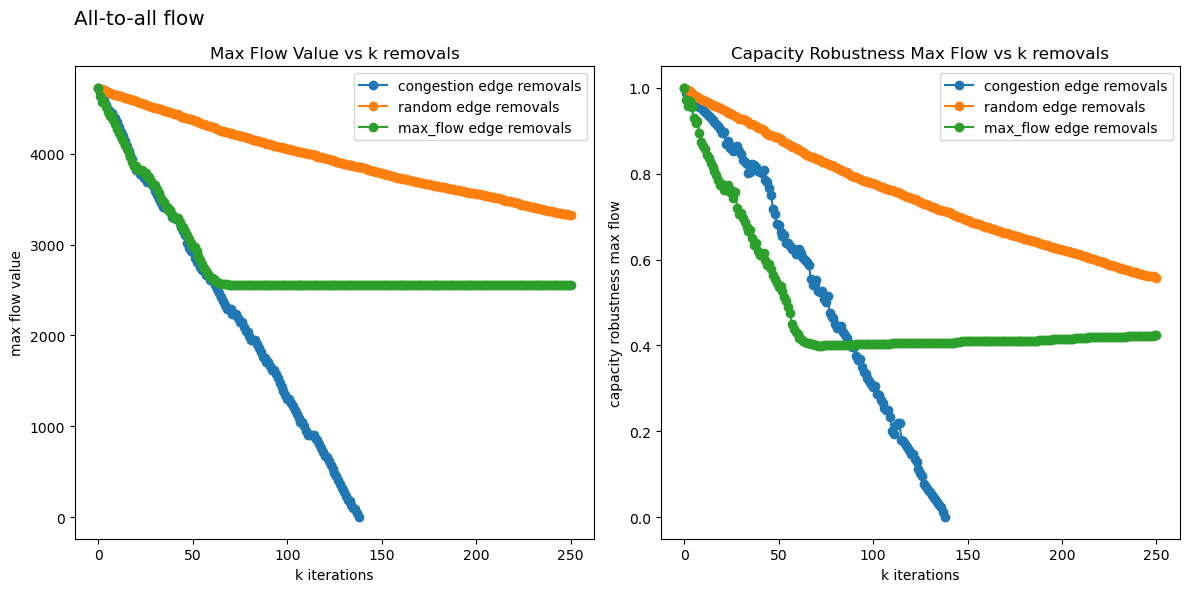

In [42]:
congestion_edge_removal_all_to_all_df = pd.read_pickle('results/congestion_edge_removal_all_to_all_df.pkl')
random_edge_removal_all_to_all_df = pd.read_pickle('results/random_edge_removal_all_to_all_df.pkl')
max_flow_edge_removal_all_to_all_df = pd.read_pickle('results/max_flow_edge_removal_all_to_all_df.pkl')

utils.plot_heuristic_comparison_biplot([congestion_edge_removal_all_to_all_df, random_edge_removal_all_to_all_df, max_flow_edge_removal_all_to_all_df], title_prefix="All-to-all flow")

----
# Flow recovery (Cai et al., 2021)

### Flow recovery pseudo-code

    Program Network Recovery
        For vj in Vs
            For vi in Vd
                If is Adjacent (vi, vj)  True
                    add node vi to network G
                    add edge {vi, vj} to network G
                End If
            End For
        End For
    End Network Recovery

vj and ni are adjacent nodes. Vd set of damaged nodes. Vs set of remaining nodes after n-k.

In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def flow_recovery(results_df_, plot_recovery=True):
    """
    Run the recovery algorithm on the network.
    """

    # Copy the results dataframe
    results_df = results_df_.copy()

    # Instantiate the recovery (results) dataframe
    recovery_df = pd.DataFrame(columns=['damage_rate', 'flow_recovery', 'flow_improvement_rate', 'recovered_grid_size'])

    # Helper function to recover the network
    def recover(df_, iteration):
        """
        Flow recovery algorithm to recover the network after damage.
        Defined in Cai et al. (2021).  
        """

        df = df_.copy()

        damaged_network = df.loc[iteration, 'network_state'].copy()
        undamaged_network = df.loc[0, 'network_state'].copy()

        # Set of remaining nodes
        Vs = list(damaged_network.nodes())

        # Set of damanged (removed) nodes
        Vd = list(undamaged_network.nodes() - damaged_network.nodes())

        reinstated_nodes = []

        # Flow recovery
        # First, add nodes to reinstate network structure
        for vj in Vs:
            for vi in Vd:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_node(vi, pos=undamaged_network.nodes[vi]['pos'], is_country_node=False, recovered_entity=True)
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                    reinstated_nodes.append(vi)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_node(vi, pos=undamaged_network.nodes[vi]['pos'], is_country_node=False, recovered_entity=True)
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)
                    reinstated_nodes.append(vi)

        # Add edges between set of reinstated nodes
        for vi in reinstated_nodes:
            for vj in reinstated_nodes:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)
        
        # Add edges between reinstated nodes and (previously) remaining nodes
        for vi in reinstated_nodes:
            for vj in Vs:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)

        # Damaged network now undergone recovery
        recovered_network = damaged_network

        damaged_flow_val = df.loc[iteration, 'max_flow_value']
        recovered_flow_val, _, _ = utils.max_flow(recovered_network, df.loc[0, 'sources'], df.loc[0, 'sinks'], show_plot=False)

        return df.loc[0, 'max_flow_value'], damaged_flow_val, recovered_flow_val, recovered_network

    init_num_nodes = results_df.loc[0, 'network_state'].number_of_nodes()

    for i in tqdm(range(1, results_df.shape[0]), desc='Recovery process'):
        optimal_max_flow, damaged_flow_val, recovered_flow_val, recovered_network = recover(results_df, iteration=i)

        damage_rate = 1 - results_df.loc[i, 'network_state'].number_of_nodes() / init_num_nodes
        flow_recovery = recovered_flow_val / optimal_max_flow
        flow_improvement_rate = None if damaged_flow_val == 0 else sigmoid(recovered_flow_val/damaged_flow_val)
        recovered_grid_size = recovered_network.number_of_nodes() / init_num_nodes

        recovery_df.loc[i] = [damage_rate, flow_recovery, flow_improvement_rate, recovered_grid_size]

    if plot_recovery:
        reversed_recovery_df = recovery_df.iloc[::-1].reset_index(drop=True)

        plt.figure(figsize=(10, 6))
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['flow_recovery'], label='flow recovery (relative to optimal)')
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['flow_improvement_rate'], label='flow improvement (relative to sub-optimal flow incurred by given grid damage)')
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['recovered_grid_size'], label='size of recovered grid (relative to initial grid size)')
        
        plt.xlabel('Grid damage rate (pct. nodes removed)')
        plt.ylabel('Recovery')
        plt.title('Flow recovery')

        # Reverse the x-axis scale
        plt.gca().invert_xaxis()

        plt.legend()
        plt.show()

    return recovery_df

### Node, random heuristic, all-to-all flow

Recovery process:   0%|          | 0/250 [00:00<?, ?it/s]

Recovery process: 100%|██████████| 250/250 [01:12<00:00,  3.47it/s]


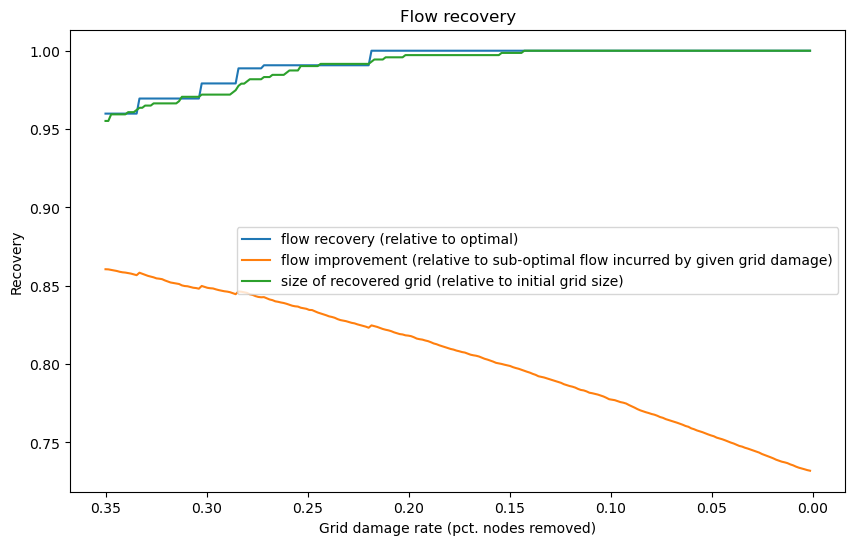

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001401,1.000000,0.731923,1.000000
2,0.002801,1.000000,0.732328,1.000000
3,0.004202,1.000000,0.732874,1.000000
4,0.005602,1.000000,0.733405,1.000000
5,0.007003,1.000000,0.733886,1.000000
...,...,...,...,...
246,0.344538,0.959854,0.859410,0.959384
247,0.345938,0.959854,0.859760,0.959384
248,0.347339,0.959854,0.860100,0.959384
249,0.348739,0.959854,0.860441,0.955182


In [45]:
# random_node_removal_all_to_all_recovery_df = flow_recovery(random_node_removal_all_to_all_df, plot_recovery=True)
# random_node_removal_all_to_all_recovery_df.to_pickle('results/random_node_removal_all_to_all_recovery_df.pkl')

random_node_removal_all_to_all_recovery_df = pd.read_pickle('results/random_node_removal_all_to_all_recovery_df.pkl')
random_node_removal_all_to_all_recovery_df

### Node, random heuristic, geopolitical flow

Recovery process: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


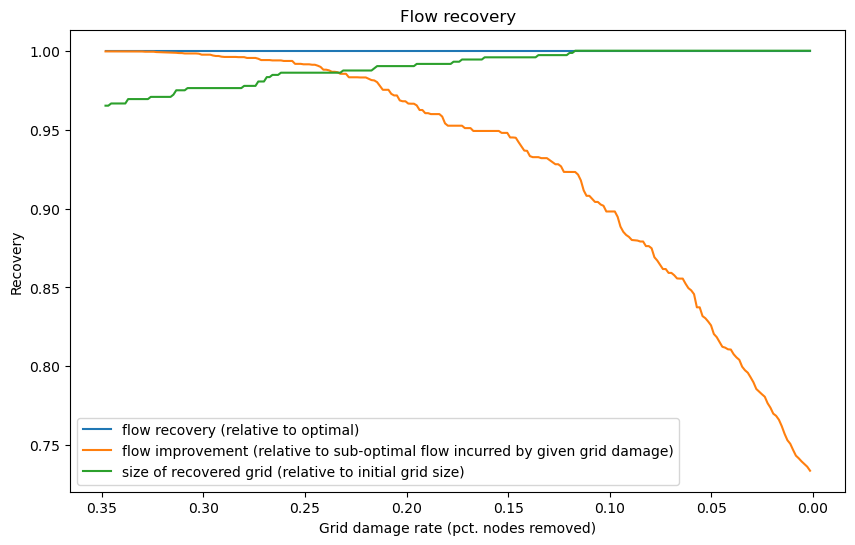

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001393,1.0,0.733872,1.000000
2,0.002786,1.0,0.736430,1.000000
3,0.004178,1.0,0.738067,1.000000
4,0.005571,1.0,0.739786,1.000000
5,0.006964,1.0,0.741743,1.000000
...,...,...,...,...
246,0.342618,1.0,0.999586,0.966574
247,0.344011,1.0,0.999586,0.966574
248,0.345404,1.0,0.999586,0.966574
249,0.346797,1.0,0.999586,0.965181


In [46]:
# random_node_removal_geopolitical_recovery_df = flow_recovery(random_node_removal_geopolitical_df, plot_recovery=True)
# random_node_removal_geopolitical_recovery_df.to_pickle('results/random_node_removal_geopolitical_recovery_df.pkl')

random_node_removal_geopolitical_recovery_df = pd.read_pickle('results/random_node_removal_geopolitical_recovery_df.pkl')
random_node_removal_geopolitical_recovery_df

### Node, max_flow heuristic, all-to-all flow

Recovery process:   0%|          | 0/150 [00:00<?, ?it/s]

Recovery process: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s]


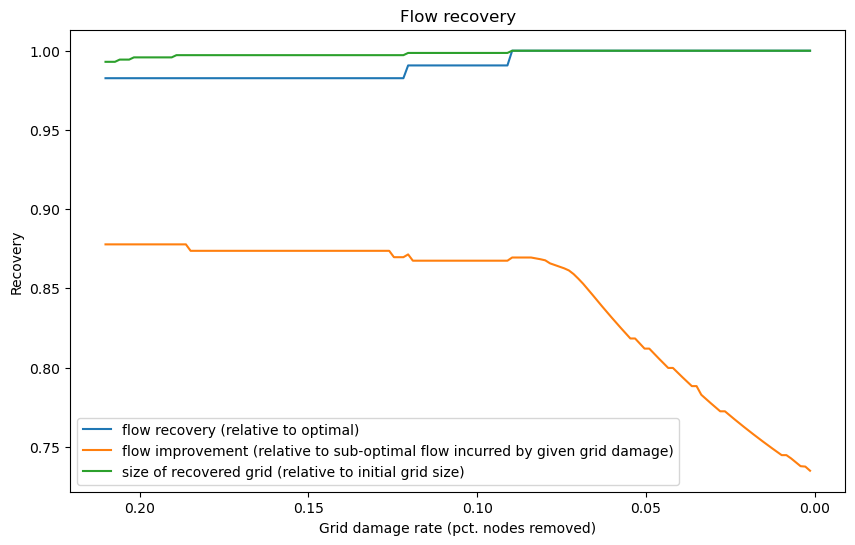

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001401,1.000000,0.734877,1.000000
2,0.002801,1.000000,0.737486,1.000000
3,0.004202,1.000000,0.737743,1.000000
4,0.005602,1.000000,0.740165,1.000000
5,0.007003,1.000000,0.742631,1.000000
...,...,...,...,...
146,0.204482,0.982655,0.877758,0.994398
147,0.205882,0.982655,0.877758,0.994398
148,0.207283,0.982655,0.877758,0.992997
149,0.208683,0.982655,0.877758,0.992997


In [47]:
# max_flow_node_removal_all_to_all_recovery_df = flow_recovery(max_flow_node_removal_all_to_all_df, plot_recovery=True)
# max_flow_node_removal_all_to_all_recovery_df.to_pickle('results/max_flow_node_removal_all_to_all_recovery_df.pkl')

max_flow_node_removal_all_to_all_recovery_df = pd.read_pickle('results/max_flow_node_removal_all_to_all_recovery_df.pkl')
max_flow_node_removal_all_to_all_recovery_df

### Node, max flow heuristic, geopolitical flow

Recovery process: 100%|██████████| 10/10 [00:00<00:00, 23.81it/s]


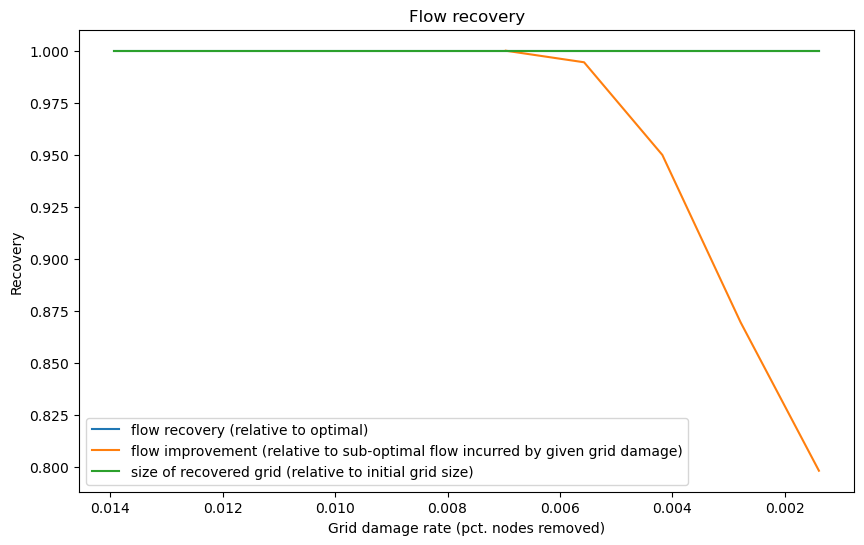

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001393,1.0,0.798196,1.0
2,0.002786,1.0,0.869471,1.0
3,0.004178,1.0,0.949916,1.0
4,0.005571,1.0,0.994450,1.0
5,0.006964,1.0,1.000000,1.0
6,0.008357,1.0,NaN,1.0
7,0.009749,1.0,NaN,1.0
8,0.011142,1.0,NaN,1.0
9,0.012535,1.0,NaN,1.0
10,0.013928,1.0,NaN,1.0


In [48]:
# max_flow_node_removal_geopolitical_recovery_df = flow_recovery(max_flow_node_removal_geopolitical_df, plot_recovery=True)
# max_flow_node_removal_geopolitical_recovery_df.to_pickle('results/max_flow_node_removal_geopolitical_recovery_df.pkl')

max_flow_node_removal_geopolitical_recovery_df = pd.read_pickle('results/max_flow_node_removal_geopolitical_recovery_df.pkl')
max_flow_node_removal_geopolitical_recovery_df